<a href="https://colab.research.google.com/github/frh02/BrainCNN/blob/master/VGG16_CNN_MRI_Brani_scans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG16 Model for Brain Tumor CT scan 

Loading the required libraries

In [32]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.optimizers import adam
from tensorflow.keras.models import Sequential

import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from google.colab import files
init_notebook_mode(connected=True)
RANDOM_SEED = 123
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting image size and the path for the data and splitting into Train,valid and test directories 

In [33]:
IMAGE_SIZE= [224,224]
train_path = '/content/drive/My Drive/MRI_brain_Dataset/TRAIN'
valid_path = '/content/drive/My Drive/MRI_brain_Dataset/VAL'
test_path ='/content/drive/My Drive/MRI_brain_Dataset/TEST'
# use predefined function to load the image data into workspace


Calling the VGG16 Model which is best for the analysis of the CT scans 

In [35]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

  
  # useful for getting number of classes
folders = glob('/content/drive/My Drive/MRI_brain_Dataset/TRAIN/*')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders),activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
opt = adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Image augmentation for the training image 

In [41]:
from keras.preprocessing.image import ImageDataGenerator
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/My Drive/MRI_brain_Dataset/TRAIN',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/MRI_brain_Dataset/VAL',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')




Found 187 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


Visualising the images of the training set 

In [42]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')


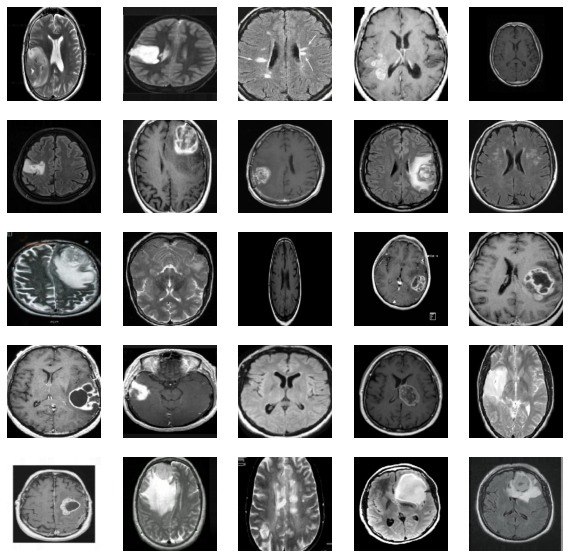

In [43]:
image_batch, label_batch = next(training_set )
show_batch(image_batch, label_batch)

Compliling the model

In [44]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=100,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/100
6/6 [==============================] - 4s 682ms/step - loss: 1.6245 - accuracy: 0.6578 - val_loss: 1.1085 - val_accuracy: 0.4906
Epoch 2/100
6/6 [==============================] - 3s 572ms/step - loss: 0.9572 - accuracy: 0.6791 - val_loss: 0.3205 - val_accuracy: 0.8868
Epoch 3/100
6/6 [==============================] - 3s 574ms/step - loss: 0.5736 - accuracy: 0.7807 - val_loss: 0.4412 - val_accuracy: 0.8491
Epoch 4/100
6/6 [==============================] - 3s 579ms/step - loss: 0.4713 - accuracy: 0.8075 - val_loss: 0.7099 - val_accuracy: 0.7547
Epoch 5/100
6/6 [==============================] - 3s 580ms/step - loss: 0.5901 - accuracy: 0.7701 - val_loss: 0.4073 - val_accuracy: 0.7358
Epoch 6/100
6/6 [==============================] - 3s 563ms/step - loss: 0.4959 - accuracy: 0.7914 - val_loss: 0.5669 - val_accuracy: 0.7925
Epoch 7/100
6/6 [==============================] - 3s 562ms/step - loss: 0.3112 - accuracy: 0.8930 - val_loss: 0.4001 - val_accuracy: 0.8679
Epoch 8/100
6

Using plots to analyse the accuracy and the loss and saving the model weights.

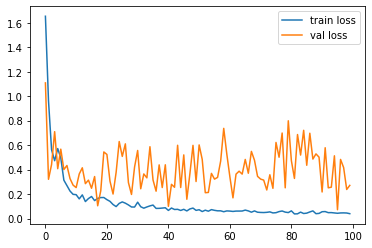

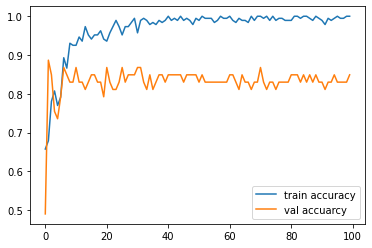

<Figure size 432x288 with 0 Axes>

In [45]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuarcy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf

from keras.models import load_model


save_path = '/content/drive'
model.save('VGG16CNN_new_model.h5',save_path)